# Controlling Glucose Metabolism in Yeast
(Based on a final project submitted by Seth Woodbury to BIOEN 599, March, 2024, University of Washington)

## Organization & Installs/Imports

In [1]:
from controlSBML import ControlSBML

import collections
import control
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tellurium as te
from sympy import symbols, Poly, fraction

In [2]:
s = control.TransferFunction.s
TIMES = np.linspace(0, 10, 100)

In [3]:
TEST_MODEL = """
$S1 -> S2; k1*S1
S2 -> S3; k2*S2

S1 = 10
S2 = 0
S3 = 0
k1 = 1
k2 = 2
k3 = 3
kP = 1
kI =1
setpoint = 1
"""
ctlsb = ControlSBML(TEST_MODEL)
TEST_RR = ctlsb.getRoadrunner()

In [4]:
k1 = TEST_RR["k1"]
k2 = TEST_RR["k2"]
tf = k1*k2/(s*(s+k2))

In [5]:
# Define functions

def evaluateTransferFunction(model, transfer_function, output_name, times=TIMES,
                             is_plot=True):
    """
    Plots simulations versus predictions.

    Args:
        model: (str) antimony
        tranfer_function (control.TransferFunction)
        output_name: (str) prediction
        times: (np.darray)
    Returns:
        float
    """
    rr = te.loada(model)
    data = rr.simulate(times[0], times[-1], len(times))
    output_name = "[" + output_name + "]"
    simulations = data[output_name]
    _, predictions = control.forced_response(transfer_function, T=times, U=1)
    rmse = np.sqrt(np.sum(simulations-predictions)**2)/len(simulations)
    if is_plot:
        plt.scatter(simulations, predictions)
        maxval = max(np.max(predictions), np.max(simulations))
        plt.plot([0, maxval], [0, maxval], color="red")
        plt.xlabel("simulated")
        plt.ylabel("predicted")
    return rmse

In [6]:
Parameters = collections.namedtuple("Parameters", "k1 k2 k3 S1 kP kI, setpoint")
def getParameters(model, **kwargs):
    """
    Retrieves constants used in the open and closed loop models.

    Args:
        model: str/Roadrunner
        kwargs: values to assign in the model

    Returns:
        Parameters
    """
    def get(name):
        if name in rr.keys():
            return rr[name]
        return 0
    #
    if isinstance(model, str):
        rr = te.loada(model)
    else:
        rr = model
    for key, value in kwargs.items():
        rr[key] = float(value)
    #
    parameters = Parameters(
        k1=get("k1"),
        k2=get("k2"),
        k3=get("k3"),
        setpoint=get("setpoint"),
        kP=get("kP"),
        kI=get("kI"),
        S1=get("S1"),
    )
    return parameters

# Tests
parameters = getParameters(model=TEST_MODEL, k1=4)
assert(isinstance(parameters, Parameters))
print("OK!")


OK!


In [7]:
def makeTransferFunctions(model, **kwargs):
    """
    Constructs the open loop and closed loop transfer functions for MODEL1.

    Args:
        model: roadrunner or antimony
        kwargs: values to use in transfer function that differ from the model.
    """
    p = getParameters(model, **kwargs)
    ol_tf = p.k1*p.k2/((s + p.k2)*(s+ p.k3))
    controller_tf = p.kP + p.kI/s
    cl_tf = control.feedback(ol_tf*controller_tf)
    return ol_tf, cl_tf

# TESTS
ol_tf, cl_tf = makeTransferFunctions(TEST_MODEL, k3=2)
assert(isinstance(ol_tf, control.TransferFunction))
assert(isinstance(cl_tf, control.TransferFunction))
print("OK!")

OK!


In [8]:
def plotPoles(model, kPs=0, kIs=0, xlim=None, is_plot=True):
    """
    Plots the open loop poles and zeroes and closed loop poles for the model.

    Args:
        model: antimony or roadrunner
        kPs: list/float
        kIs: list/float
        xlim: tuple (limits of x-axis on plot)

    Returns:
        control.TransferFunction (open loop)
        control.TransferFunction (closed loop)
    """
    p = getParameters(model)
    if isinstance(kPs, int) or isinstance(kPs, float):
        kPs = [kPs]
    if isinstance(kIs, int) or isinstance(kIs, float):
        kIs = [kIs]
    if len(kPs) == 1:
        kPs = np.repeat(kPs[0], len(kIs))
    if len(kIs) == 1:
        kIs = np.repeat(kIs[0], len(kPs))
    #
    annotations = []
    cl_poles = []
    for kI in kIs:
        for kP in kPs:
            ol_tf, cl_tf = makeTransferFunctions(model, kP=kP, kI=kI)
            for pole in cl_tf.poles():
                annotations.append("%2.2f, %2.2f" % (kP, kI))
                cl_poles.append(pole)
    annotations.extend(annotations)
    cl_poles = np.array(cl_poles)
    if is_plot:
        _, ax = plt.subplots(1)
        ol_poles = ol_tf.poles()
        ax.scatter(ol_poles.real, ol_poles.imag, marker="o", c="red")
        ax.scatter(cl_poles.real, cl_poles.imag, marker="*", c="blue")
        _ = [ax.annotate(t, (p.real, p.imag), fontsize=8) for t, p in zip(annotations, cl_poles)]
        ax.set_xlabel("Real")
        ax.set_ylabel("Imaginary")
        _ = ax.set_title("Open and closed loop poles for kP, kI.")
        if xlim is not None:
            ax.set_xlim(xlim)

# Tests
plotPoles(TEST_MODEL, kPs=[0.01, 0.1, 10, 100], is_plot=False)
print("OK!")

OK!


In [9]:
def plotModel(model, times=TIMES, is_plot=True, title="", selections=None,
              figsize=(5,5), ylim=None, **kwargs):
    """
    Plots a model.

    Args:
       times: np.array
       kwargs: values of parameters
    Returns:
       NamedArray
    """
    rr = te.loada(model)
    for key, value in kwargs.items():
        rr[key] = value
    if selections is None:
        data = rr.simulate(times[0], times[-1], len(times))
    else:
        if not "time" in selections:
            selections.insert(0, "time")
        data = rr.simulate(times[0], times[-1], len(times), selections=selections)
    if is_plot:
        if ylim is None:
            rr.plot(title=title, figsize=figsize)
        else:
            rr.plot(title=title, figsize=figsize, ylim=ylim)
    return data

# TESTS
data = plotModel(TEST_MODEL, k1=0.1, is_plot=False, selections=["S2"], ylim=[0, 10])
assert(len(data) > 0)
print("OK!")

OK!


In [10]:
def buildPITestbed(model, input_name, output_name, sign=1):
    """
    Creates an Antimony model of a PI controller using model as the open loop system.
    The resulting model as Antimony parameters for the setpoint, kP, kI. Assumes that
    this is a modular model (has an "end" statement).

    Args:
        model: str (Antimony model of OLS)
        input_name: str (name of a species in the OLS)
        output_name: str (name of a species in the OLS)
        sign: int (directional effect of input on output)

    Returns:
        str (Antimony model)
    """
    # Control codes
    control_logic = """
        // Parameters in CLS
        setpoint = 1
        kP = 1
        kI = 0
        sign = {sign}

        // Controller
        control_error := sign*(setpoint - {output_name})
        integral_control_error = 0
        integral_control_error' = control_error
        ${input_name} := kP*control_error + kI*integral_control_error
        """
    # Partition the model
    try:
        end_pos = model.index("end")
    except:
        end_pos = len(model) - 1
    model_front = model[:end_pos]
    model_back = model[end_pos:]
    return model_front + control_logic.format(input_name=input_name, output_name=output_name, sign=sign) + model_back

# TESTS
is_plot = False
cl_model = buildPITestbed(TEST_MODEL, "S1", "S3")
rr = te.loada(cl_model)
rr["kP"] = 10
rr["kI"] = 5
rr["setpoint"] = 8
rr.simulate(0, 10, 100, selections=["time", "setpoint", "S3"])
if is_plot:
    rr.plot()
print("OK!")

OK!


## Section 1: Problem Description & System Definition 

### Problem Description & Control Objectives

**IMPORTANT LINKS:**

<u>Selected Biomodel:</u> Nishio2008 - Design of the phosphotransferase system for enhanced glucose uptake in E. coli

<u>Biomodel URL:</u> https://www.ebi.ac.uk/biomodels/BIOMD0000000571

<u>Publication URL:</u> https://www.embopress.org/doi/full/10.1038/msb4100201

**PROBLEM DESCRIPTION:**

Industrial bioreactors culturing engineered microbes present a cost-effective, highly efficient, minimal-resource cost, and eco-friendly method of producing large quantities of desirable proteins and complex organic compounds for societal use (e.g., academia, therapeutics, industrial chemistry, biotechnology sectors). The biological problem I am addressing regards controlling Escherichia coli (E. coli) glucose uptake for such industrial microbe engineering purposes since they are the most well-studied and commonly used microbe. From a bioreactor production standpoint, it is desirable to have E. coli uptake as much glucose as possible for the ultimate production of ATP and the desired plasmid product(s) they were engineered to produce (i.e., protein products or protein machinery to make small organic molecules). However, E. coli have evolved to highly regulate their glucose uptake for the optimal cooperative survival and proliferation of their colonies; if they sense low glucose in the environment, they will try to use other carbon sources and metabolites for energy and they will shift toward conservative/catabolic metabolic processes rather than the anabolic ones we want them to perform. Ideally, we want E. coli in a bioreactor to initially divide to a certain concentration, then we want to induce them to grow as fat as possible (taking in the maximal possible glucose as fuel) to become full of our intended product before we lyse them all to harvest our product.

E. coli have evolved a complex phosphotransferase system that acts in a biological circuit to control the transfer of glucose into the cell while simultaneously phosphorylating it. The specific biological problem that I will be engineering in this system is how to control and enhance the concentration of ``phosphorylated EI`` or ``EI_P`` from the gene ptsI. The phosphotransfer of the phosphate on phosphoenolpyruvate to EI making EI_P is the first step in the phosphotransferase cascade system that ultimately phosphorylates glucose and transports it into the cell. This reaction is also thought to be the rate-limiting step in glucose intake so aiming to control and upregulate EI_P concentration will push equilibrium towards a higher glucose intake.

**CONTROL OBJECTIVES:**

In the given model, the extracellular glucose concentration is held constant which could mimic a bioreactor that is continuously feeding E. coli glucose while they divide and grow before their plasmid expression is induced. At t = 500 minutes in the model the glucose levels drop instantaneously by several orders of magnitude to cause a perturbation (see below). As a reminder, we want to resist ``EI_P`` decrease at all costs and ideally minimize its increase from the reverse of the phosphotransferase cascade since the last step depends partially on glucose concentration and each phosphate transfer is reversible. **Thus, our control objectives are:**
* Keep the ``EI_P`` concentration in the range above 2.4e-7M at all costs but ideally [2.4e-7 M, 4.0e-7 M] for at least 720 minutes (12 hours).
* Minimize any potential concentration oscillations and keep the oscillations within the concentration range above.
* Converge to a stable, steady-state system after the glucose decrease at t = 500 minutes within 120 minutes (t = 620 minutes).
* With each additional step this setting time should also be within t = 30 minutes & the final ``EI_P`` should steady out.

Achieving these control objectives will allow our engineered E. coli to keep maximally uptaking glucose even after we shut down its continuous flow into the bioreactor. Keeping the ``EI_P`` range above 2.4e-7 M is significant because this is its steady-state concentration at glucose concentrations that are magnitudes higher at t < 500 minutes, so maintaining an ``EI_P`` this high after t = 500 minutes will mean the E. coli are still uptaking glucose at a similar rate as before. Keeping it below 3.4e-7 M is a good sign that the rest of the phosphotransferase cascade is not backing up or slowing down significantly. Cells enjoy homeostasis and consistency, so minimizing ``EI_P`` oscillations will be important to not throw off other equilibriums that are not necessarily modeled here with respect to glucose uptake, we want a continuous flux of glucose coming in that keeps our E. coli busy at making proteins. Finally, 30 minutes is a pretty short time for E. coli so it would be desirable if the system could converge within 30 minutes so the E. coli are not thrown out of homeostasis.

#### Antimony Model

In [55]:
###############################################################################
### OBTAIN SOURCE FILE FROM URL & LOAD TELLURIUM SBML MODEL + VIEW ANTIMONY ###
###############################################################################

# Assign file URL to a variable
TIMES = np.linspace(000, 1500, 5000)
BIOMODEL_SOURCE_FILE_URL = "https://www.ebi.ac.uk/biomodels/services/download/get-files/MODEL1501300000/3/BIOMD0000000571_url.xml"

# Create tellurium SBML model & print the antimony
CTLSB = ControlSBML(BIOMODEL_SOURCE_FILE_URL, xlabel="time (min)", times=TIMES)
ANTIMONY_MODEL_EI_P = CTLSB.getAntimony()
print(ANTIMONY_MODEL_EI_P)

// Created by libAntimony v2.13.2
model *MODEL1501300000()

  // Compartments and Species:
  compartment cyt;
  species CRP in cyt, CRPsiteI_crp in cyt, CRPsiteII_crp in cyt, CRPsite_cyaA in cyt;
  species CRPsite_genome in cyt, CRPsite_ptsGp1 in cyt, CRPsite_ptsGp2 in cyt;
  species CRPsite_ptsHp0 in cyt, CRPsite_ptsHp1 in cyt, CRPsite_ptsIp0 in cyt;
  species CRPsite_ptsIp1 in cyt, CRPsite_mlcp1 in cyt, CRPsite_mlcp2 in cyt;
  species Mlc in cyt, Mlcsite_mlcp1 in cyt, Mlcsite_mlcp2 in cyt, Mlcsite_ptsGp1 in cyt;
  species Mlcsite_ptsGp2 in cyt, Mlcsite_ptsHp0 in cyt, Mlcsite_ptsIp0 in cyt;
  species CRP_cAMP in cyt, CRP_cAMP_CRPsiteI_crp in cyt, CRP_cAMP_CRPsiteII_crp in cyt;
  species CRP_cAMP_CRPsite_cyaA in cyt, CRP_cAMP_CRPsite_genome in cyt, CRP_cAMP_CRPsite_ptsGp1 in cyt;
  species CRP_cAMP_CRPsite_ptsGp2 in cyt, CRP_cAMP_CRPsite_ptsHp0 in cyt;
  species CRP_cAMP_CRPsite_ptsHp1 in cyt, CRP_cAMP_CRPsite_ptsIp0 in cyt;
  species CRP_cAMP_CRPsite_ptsIp1 in cyt, CRP_cAMP_CRPsite_ml

#### Preliminary Investigation

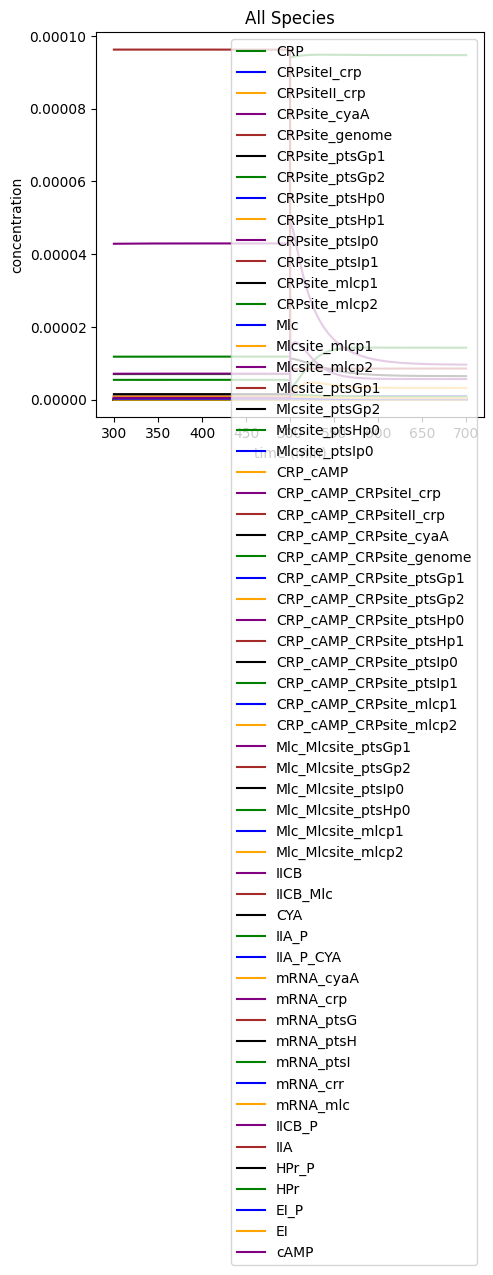

In [12]:
_ = CTLSB.plotModel(times=TIMES, legend=True, title="All Species")

We can see that at t = 500 the sudden change in glucose quickly perturbes the system but it seems to quickly return to homeostasis. There are a ton of things being modeled here so let's take a look at ``EI_P``:

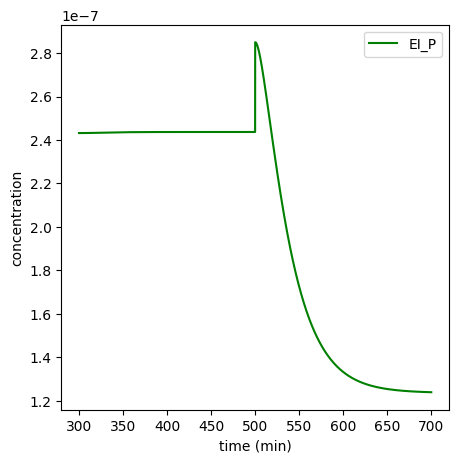

In [13]:
_ = CTLSB.plotModel(times=TIMES, selections=["EI_P"], legend=True)

There it is, the glucose drop at t = 500 minutes causes a rapid backup in the phosphotransferase cascade due to the last species not being able to recruit glucose so quickly due to mass action and therefore ``EI_P`` accumulates before the genetic circuit catches up and calls for less EI protein production.

### System Definition

Remember that a system is defined by the following:
1. SBML model
1. Output
1. Input
1. Directional effect of the input on the output - agonist vs antagonist
1. Operating region for the input - range of input that gives output that makes sense
1. Range of outputs that can be achieved

We have already specified the SBML model and the ``EI_P`` output in our problem statement. Thus, we now seek to find an input that controls ``EI_P``.

#### Antimony Model

In [14]:
#######################################
### IDENTIFY INPUT FLOATING SPECIES ###
#######################################

# Create a controllable SMBL variable
control_sbml_for_input_species = ControlSBML(ANTIMONY_MODEL_EI_P)

# Print the possible inputs
print(control_sbml_for_input_species.getPossibleInputs())

boundary_species:	cyaA, cyaA_basal, crp, crp_basal, ptsGp1, ptsGp2, ptsHp0, ptsHp1, ptsIp0, ptsIp1, crr, mlcp1, mlcp2, Pyr, PEP, Glc6P, Glucose, ATP

floating_species:	CRP, CRPsiteI_crp, CRPsiteII_crp, CRPsite_cyaA, CRPsite_genome, CRPsite_ptsGp1, CRPsite_ptsGp2, CRPsite_ptsHp0, CRPsite_ptsHp1, CRPsite_ptsIp0, CRPsite_ptsIp1, CRPsite_mlcp1, CRPsite_mlcp2, Mlc, Mlcsite_mlcp1, Mlcsite_mlcp2, Mlcsite_ptsGp1, Mlcsite_ptsGp2, Mlcsite_ptsHp0, Mlcsite_ptsIp0, CRP_cAMP, CRP_cAMP_CRPsiteI_crp, CRP_cAMP_CRPsiteII_crp, CRP_cAMP_CRPsite_cyaA, CRP_cAMP_CRPsite_genome, CRP_cAMP_CRPsite_ptsGp1, CRP_cAMP_CRPsite_ptsGp2, CRP_cAMP_CRPsite_ptsHp0, CRP_cAMP_CRPsite_ptsHp1, CRP_cAMP_CRPsite_ptsIp0, CRP_cAMP_CRPsite_ptsIp1, CRP_cAMP_CRPsite_mlcp1, CRP_cAMP_CRPsite_mlcp2, Mlc_Mlcsite_ptsGp1, Mlc_Mlcsite_ptsGp2, Mlc_Mlcsite_ptsIp0, Mlc_Mlcsite_ptsHp0, Mlc_Mlcsite_mlcp1, Mlc_Mlcsite_mlcp2, IICB, IICB_Mlc, CYA, IIA_P, IIA_P_CYA, mRNA_cyaA, mRNA_crp, mRNA_ptsG, mRNA_ptsH, mRNA_ptsI, mRNA_crr, mRNA_mlc, IICB_P, I

As mentioned, there are many outputs and boundaries in this model system. Some genetic or protein controls might be helpful. This evolved system already has 'accelerator' and 'decelerator' controls built into it, we are attempting to hijack those controls and essentially 'control the controls.' In practice, this could be something like amplifying certain genes in the E. coli DNA, adding new genes to their DNA, or deleting genes from their DNA. Based on the publication, here are some possible 'controls to control:'
* CRPsite_ptsIp1 or CRPsite_ptsIp0 (promoters or enhancer sites for EI gene)
* CRPsiteII_crp or CRPsiteI_crp (promoters or enhancer sites for sensor genes that upregulate 'acceleration')
* mRNA_ptsI (directly produces EI protein)
* mRNA_crp (directly produces sensor protein)
* Mlc or mRNA_mlc (downregulates phosphotransferase cascade & EI protein production)

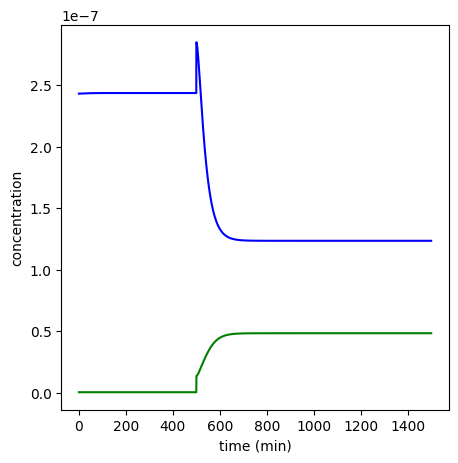

In [57]:
###################################################
### VISUALIZE IF ANYTHING HAS CONTROL OVER EI_P ###
###################################################
INPUT_NAME = "Mlc"
OUTPUT_NAME = "EI_P"
CTLSB.setSystem(input_name=INPUT_NAME, output_name=OUTPUT_NAME)
_ = CTLSB.plotModel(selections=[INPUT_NAME, OUTPUT_NAME])

Mlc seems like it could be an antagonist to the concentration of ``EI_P``. Note that I tried many different values for the time series to convert it to the right units, I tried across multiple orders of magnitude but nothing worked to detect the fluctuation at t = 500 minutes. For whatever reason it is giving a perturbation at t = 0 minutes so I thought that would be sufficient to view the relationships between different inputs and the output, like we see here. Now let us try a staircase: 

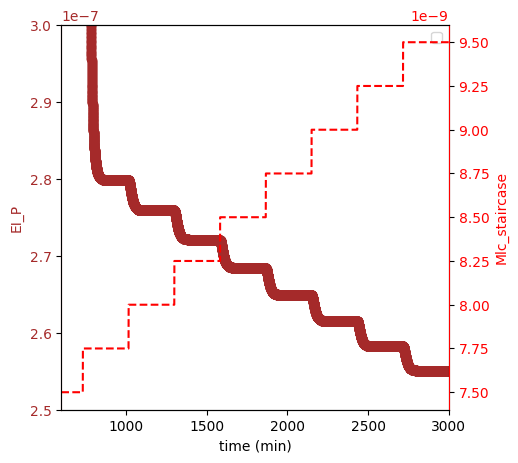

In [48]:
#######################################################################
### PLOT STAIRCASE FUNCTION & OBSERVE FOR GLUCOSE CHANGE AT 500 MIN ###
#######################################################################
STAIRCASE_TIMES = np.linspace(450, 3000, 20000)
_ = CTLSB.plotStaircaseResponse(initial_value=7.5*1e-9, final_value=9.5*1e-9, num_step=8,
                                times=STAIRCASE_TIMES,
                                ylim=[2.5*1e-7, 3*1e-7],
                               xlim=[600, 3000])

We are way overshooting, remember we want to keep EL_P below 4.0e-7 M. This means our control is working, lowering Mlc does increase El_P, but it is increasing it too much. We do not want a spike that is going to throw our E. coli into a panic. Also remember that we do not care about time points before 500 minutes because it is a steady-state, stable system with no interesting behavior because the glucose concentration is fixed. It is more interesting to see a rapid perturbation and the recovery to equilibrium, as this is most likely what E. coli will more realistically experience in a bioreactor - a shutoff of glucose supplement and the rapid decline of any glucose left in the solution with the E. coli.

In [17]:
###########################################################################################
### PLOT A STAIRCASE FUNCTION & ATTEMPT TO FIND THE OPERATING REGION WITH (-)-STAIRCASE ###
###########################################################################################

# Create permanenent control sbml
CONTROL_SBML = ControlSBML(ANTIMONY_MODEL_EI_P, figsize=(10, 5), times=np.linspace(0, 1000, 100000), markers=False, 
                           input_names=[INPUT_NAME], output_names=[OUTPUT_NAME])


# Plot staircase
_ = CONTROL_SBML.plotStaircaseResponse(initial_value=0.00000002, final_value=0.000000007, times=np.linspace(450, 800, 20000),
                                      )#ylim=[0.0000002, 0.0000003])

ValueError: Invalid keyword arguments: {'output_names', 'input_names'}

Getting close! Let's increase our the end time to our goal, and while we're at it let's shoot for ~1220 minutes (12 hours after t = 500 min) the usual time E. coli will incubate after inducing plasmid expression (i.e., production of the desired product)!

In [ ]:
############################################################################################
### PLOT A STAIRCASE FUNCTION & ATTEMPT TO FIND THE OPERATING REGION WITH (-)-STAIRCASE  ###
############################################################################################

# Create permanenent control sbml
CONTROL_SBML = ControlSBML(ANTIMONY_MODEL_EI_P, figsize=(10, 5), times=np.linspace(0, 1000, 100000), markers=False, 
                           input_names=[INPUT_NAME], output_names=[OUTPUT_NAME])


# Plot staircase
_ = CONTROL_SBML.plotStaircaseResponse(initial_value=0.00000001, final_value=0.000000008, times=np.linspace(450, 1250, 20000),
                                      )#ylim=[0.0000002, 0.0000003])

This plot achieves all of our control objectives except the initial perturbation goes slightly higher than we'd like. We can fix this later with PI control! For now, let us focus on improving the time resolution where our control objectives are currently met; thus, we can ignore the initial perturbation (for now).

In [ ]:
###################################################################################################
### REFINE THE SYSTEM IN TIME TO IGNORE THE INITIAL PERTURBATION FOR NOW & ADD TIME RESOLUTEION ###
###################################################################################################

# Important note: this was Prof. Hellerstein's suggestion from HW1

_ = CONTROL_SBML.plotStaircaseResponse(initial_value=0.000000009, final_value=0.0000000075, times=np.linspace(440, 1400, 20000),
                                      ylim=[0.00000026, 0.0000003], xlim=[700, 1420])

This system with additional time resolution has successfully achieved reasonable control over the EIP output with the Mlc input. Furthermore, we successfully achieved the **following control objectives:**

* Kept the ``EI_P`` concentration in the range above 2.4e-7 M for over 720 minutes (12 hours) past t = 500 minutes. 
* Eliminated/minimized any potential concentration oscillations, although none were expected. 
* Converged to a stable, steady-state system after the glucose decreased within ~120 minutes before the staircase shift.
* With each additional step this setting time was drastically reduced to about ~30 minutes.

Ultimately, the final plot above achieves the control objectives by stabilizing as a nearly horizontal line within the desired setpoints after the initial glucose perturbation at t = 500 minutes. After the glucose perturbation, each step decrease in Mlc protein concentration increases the concentration of ``EI_P`` as expected since Mlc inhibits the production of EI protein. Thus, they are antagonistic. There are no oscillations about a setting point observed at any time which demonstrates that the second control objective was achieved. The third control objective can be noted at the time t = 575 minutes where the post-perturbation ``EI_P`` concentration stops growing and begins to drastically flatten out before the staircase decreases (plot above this one). Finally, the final control objective was achieved because the right tail is nearly horizontal and each step down on the staircase only increases the tail line for about 30 minutes before it becomes horizontal again.

Below, we provide the complete **revised system definition:**

1. SBML model: Nishio2008 - Design of the phosphotransferase system for enhanced glucose uptake in E. coli from Biomodels
1. Output: ``EI_P``
1. Input: ``Mlc``
1. Directional effect of the input on the output: Monotone ``EI_P`` decreases for stepwise ``Mlc`` increases
1. Operating region for the input: [7.6e-9 M, 8.4e-9 M]
1. Range of outputs that can be achieved [2.65e-7 M, 2.85e-7 M]

## Section 2: System Identification

### System Identification

System identification describes the system as a transfer function for the operating point specified in system definition. In our system, the input is ``Mlc`` and the output is ``EI_P``. ``Mlc`` is varied over the operating region of [7.6e-9, 8.0e-9]. The method ``plotTransferFunctionFit`` estimates to transfer function and plots the fit. It returns a Timeseries (a dataframe with the data plotted) and an AntimonyBuilder (the Antimony code run to produce the fitting data).

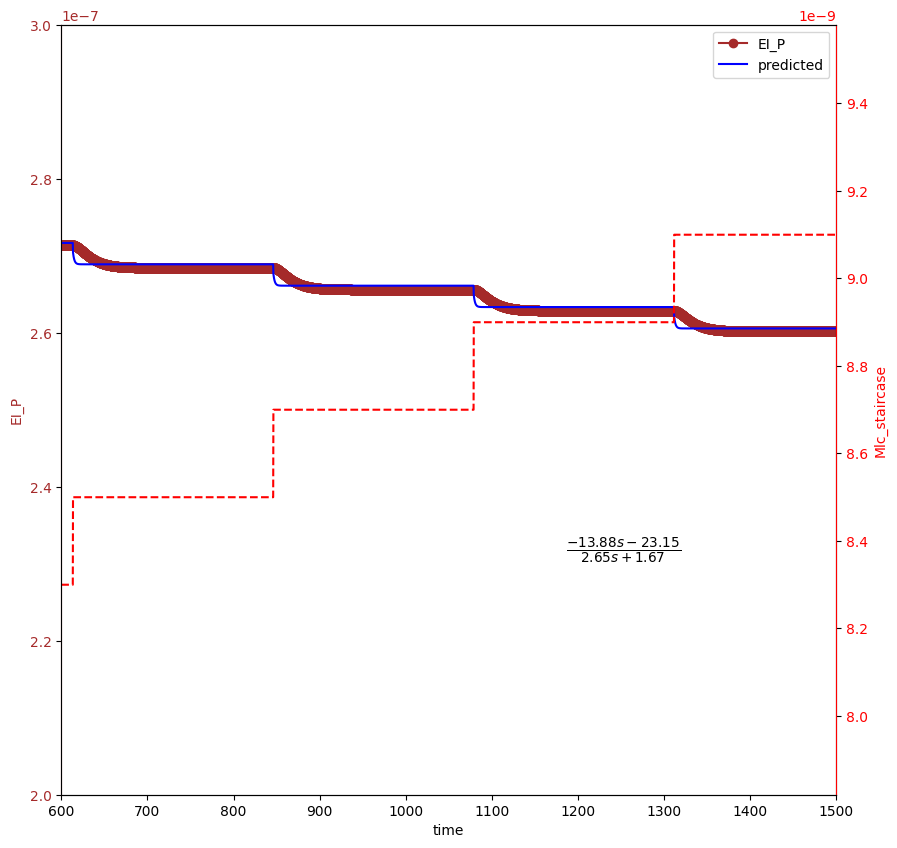

TransferFunction(array([-13.87916085, -23.15183568]), array([2.64794455, 1.66810054]))

In [61]:
###################################
### INITIAL GUESS & OBSERVATION ###
###################################
_ = CTLSB.plotTransferFunctionFit(num_zero=1, num_pole=1, 
    initial_value=7.5*1e-9, final_value=9.5*1e-9, num_step=10,
                                times=STAIRCASE_TIMES,
                                ylim=[2*1e-7, 3*1e-7],
                                  fit_start_time=1000,
                               xlim=[600, 1500],
                                 fitter_method="gpz")

# Get the transfer function 
TRANSFER_FUNCTION = CTLSB.getOpenLoopTransferFunction()
TRANSFER_FUNCTION

This looks like an awful fit and similar tries with different num_numerators and num_denominators yielded similar graphs. This is because it is still trying to fit the perturbation behavior that happens at t = 500 min. I cannot start the np.linspace at t = 700 because the function does not converge and I get an error. Thus, I need to see if I can change where the fitting of the transfer function starts. To do this, I need to go find what is happening in the background of this function, so the cell below helps us identify where the ``plotTransferFunctionFit`` is on GitHub.

In [ ]:
#########################################################
### INITIAL GUESS USING FIT_START_TIME + FIT_END_TIME ###
#########################################################

# Plot
_ = CONTROL_SBML.plotTransferFunctionFit(num_numerator=2, num_denominator=2, 
                                         initial_value=0.000000009, final_value=0.0000000075,
                                         times=np.linspace(440, 1420, 10000),
                                         ylim=[0.00000026, 0.0000003], xlim=[700, 1420],
                                         fit_start_time=700, fit_end_time=1420) # ADDED PARAMETERS

# Get the transfer function 
TRANSFER_FUNCTION = CONTROL_SBML.getOpenLoopTransferFunction()
TRANSFER_FUNCTION

In [ ]:
#############################################################################################
### ATTEMPTING TO FIT USING FIT_START_TIME + FIT_END_TIME & DIFFERENT CONSTRAINED FITTING ###
#############################################################################################

# Plot
_ = CONTROL_SBML.plotTransferFunctionFit(num_numerator=1, num_denominator=3, 
                                         initial_value=0.000000009, final_value=0.0000000075,
                                         times=np.linspace(440, 1420, 10000),
                                         ylim=[0.00000026, 0.0000003], xlim=[700, 1420],
                                         fit_start_time=650) # ADDED PARAMETERS

# Get the transfer function 
TRANSFER_FUNCTION = CONTROL_SBML.getOpenLoopTransferFunction()
TRANSFER_FUNCTION

In [ ]:
##############################################
### PLOT THE POLES TO SEE WHAT IS GOING ON ###
##############################################

TRANSFER_FUNCTION.poles(), TRANSFER_FUNCTION.zeros()

This is so strange, the transfer function does not want to fit in the positive direction that EI_P is going when Mlc is decreasing. However, the shape looks nice with 2 terms in the numerator and 3 terms in the denominator for the window we care about, 700 minutes to 1420 minutes; additionally, both poles are currently real and negative indicating that the system converges. One pole is very close to zero indicating a long setting time, but this is okay.

In [ ]:
################################################################################################################
### ATTEMPTING TO FIT USING FIT_START_TIME + FIT_END_TIME & DIFFERENT CONSTRAINED FITTING & CHANGED NUM_STEP ###
################################################################################################################

# Plot
_ = CONTROL_SBML.plotTransferFunctionFit(num_numerator=2, num_denominator=3, 
                                         #initial_value=0.000000009, final_value=0.0000000075,
                                         times=np.linspace(440, 1420, 10000),
                                         #ylim=[0.00000026, 0.0000003], xlim=[700, 1420],
                                         fit_start_time=650, num_step = 10, 
                                         is_steady_state = False) # ADDED PARAMETERS

# Get the transfer function 
TRANSFER_FUNCTION = CONTROL_SBML.getOpenLoopTransferFunction()
TRANSFER_FUNCTION

We got the correct direction finally! However, this identified system is subpar at best and we must proceed with extreme caution using this transfer function. This was the best transfer function that I was able to find and the only one with the correct direction, but ultimately I would say our system identification was inadequate. We will use this transfer function in Section 3.

### System Identification Inadequacy 

**INITIAL THOUGHTS:**

I tried doing everything that I could to think of to change the transfer function behavior and spent a solid few hours looking through the GitHub trying to understand what was going on under the hood of this function, trying different arguments, etc. It looks like it has a great shape and will fit very nicely if the plotTransferFunctionFit knew to look at possible fits that negatively correlate with the input variable. I suspect a few things could be going on: 

1.) The threshold in the function isDone (siso_transfer_function_builder.py) might be too high since my inputs and outputs are so small the residuals probably are very tiny and seem highly accurate/pass the threshold with relative ease. This maybe truncates the search for a global minimum and settles for a local minimum with the rmse for the residuals.

2.) Perhaps the function is too highly dependent on a random initial guess for each coefficient, as I see that it is a random integer between -10 and 10. Perhaps there is an error executing this logic that biases it to be positive and not negative, like we would expect to see in our transfer function.

3.) Perhaps the logic was being flipped somewhere for having an opposite initial value and opposite final value.

Let us zoom out and take a more global view of the plot to give us insight into what is going on.

In [ ]:
################################################################################
### ZOOMED OUT PLOT OF A TRANSFER FUNCTION THAT HAS INCORRECT DIRECTIONALITY ###
################################################################################

# Plot
_ = CONTROL_SBML.plotTransferFunctionFit(num_numerator=2, num_denominator=3, 
                                         initial_value=0.000000009, final_value=0.0000000075,
                                         times=np.linspace(440, 1420, 10000),
                                         #ylim=[0.00000026, 0.0000003], xlim=[700, 1420],
                                         fit_start_time=650, num_step = 10, 
                                         is_steady_state = False) # ADDED PARAMETERS

# Get the transfer function 
TRANSFER_FUNCTION = CONTROL_SBML.getOpenLoopTransferFunction()
TRANSFER_FUNCTION

**FINAL THOUGHTS:**

Looking at the above plot it is clear that the transfer function does map the predicted inputs relatively well to the EI_P output for staircase control. The ``plotTransferFunctionFit`` on GitHub works by making a transfer function of the input num_numerators & num_demoninators with initial random coefficients. It then iteratively modifies the coefficients of the transfer function based on the outcome of the RMSD between the predicted EI_P output and actual EI_P output; specifically, changes made to the coefficients are accepted when the RMSD is minimized from the previous RMSD and this process repeats by changing the new coefficients until a threshold minimized RMSD is achieved. Once this threshold is achieved, the function stops the minimization. I believe this threshold was around 1e-5 or 1e-6 which is a low RMSD in most cases. However, observe the scales in our case: we are on a scale of 1e-7! Thus, it is super easy to achieve an RMSD below this threshold in this case because of the small scale of our inputs and outputs, a threshold RMSD here should be closer to 1e-8. 

Ultimately, I suspect that the ``plotTransferFunctionFit`` function is getting stuck at a local minimum in its search for a transfer function that yields a global minimum RMSD because it stops searching early due to the poor RMSD threshold for this specific case. This high RMSD threshold yields poor resolution for fitting at our minute scales, and therefore a transfer function is not able to be constructed with great attention to detail at the scales of which these reactions are happening in E. coli. Thus, this problem could possibly be solved by allowing the RMSD threshold to be toggled by the user for each specific case.

## Section 3: Testbed Construction & Control Design

### Testbed Construction

I will perform initial testbed construction with the ``plotClosedLoop`` function from the analysis of mTor since Professor Hellerstein had trouble loading my raw antimony file in HW1. This allows us to keep using CONTROL_SBML rather than loading in the antimony and pasting kP & kI in by hand.

#### kP, kI, & kP-kI Initial Guesses

In [ ]:
############################################################
### CREATE TESTBED WITH SIMPLE kP CONTROL | RANDOM GUESS ###
############################################################

_, builder = CONTROL_SBML.plotClosedLoop(setpoint=0.0000003, kP=1, kI=None, kF=None,                                          
                                         times=np.linspace(440, 1420, 10000),
                                         #ylim=[0.00000020, 0.0000004], xlim=[700, 1420],
                                        )

We see that proportional control achieves a stable system as seen by the horizontal line that settles quickly after the perturbation, but we are way off our set point here with a simple guess for kP. Let us try I control:

In [ ]:
############################################################
### CREATE TESTBED WITH SIMPLE kI CONTROL | RANDOM GUESS ###
############################################################

_, builder = CONTROL_SBML.plotClosedLoop(setpoint=0.0000003, kP=None, kI=1, kF=None,                                          
                                         times=np.linspace(440, 1420, 10000),
                                         #ylim=[0.00000020, 0.0000004], xlim=[700, 1420],
                                        )

With a simple guess for I control only, we see our system output blow up after the perturbation and the Mlc concentration does not seem to change. Let us now try a simple PI controller:

In [ ]:
#################################################################
### CREATE TESTBED WITH SIMPLE kI & kP CONTROL | RANDOM GUESS ###
#################################################################

_, builder = CONTROL_SBML.plotClosedLoop(setpoint=0.0000003, kP=1, kI=1, kF=None,                                          
                                         times=np.linspace(440, 1420, 10000),
                                         #ylim=[0.00000020, 0.0000004], xlim=[700, 1420],
                                        )

This behavior seems similar to the P control potentially indicating that the kP is too dominant here. Now let us begin exploring PI controls by changing kP and kI.

#### Iterative Exploration to Converge Toward a Satisfactory Control with PI Controller

In [ ]:
#################################################################################
### CREATE TESTBED WITH SIMPLE kI & kP CONTROL | 1ST ITERATION OF EXPLORATION ###
#################################################################################

_, builder = CONTROL_SBML.plotClosedLoop(setpoint=0.0000003, kP=.01, kI=.001, kF=None,                                          
                                         times=np.linspace(440, 1420, 10000),
                                         ylim=[0.0000001, 0.0000005], xlim=[450, 1420],
                                        )

Scaling down the PI control by inputting a smaller kP and kI in this closed system is now giving some more interesting behavior! We are closer to our setpoint and the perturbation at t = 500 min is not as influential now.

In [ ]:
#################################################################################
### CREATE TESTBED WITH SIMPLE kI & kP CONTROL | 2ND ITERATION OF EXPLORATION ###
#################################################################################

_, builder = CONTROL_SBML.plotClosedLoop(setpoint=0.0000003, kP=.001, kI=-.001, kF=None,                                          
                                         times=np.linspace(440, 1420, 10000),
                                         ylim=[0.0000001, 0.0000005], xlim=[450, 1420],
                                        )

We are beginning to hit the set point now! Wow, this is looking fantastic the perturbation at t = 500 minutes is still not ideal, but we converge to a steady state pretty quick. Making kI negative helped to achieve our setting point goal. Let us keep exploring:

In [ ]:
#################################################################################
### CREATE TESTBED WITH SIMPLE kI & kP CONTROL | 3RD ITERATION OF EXPLORATION ###
#################################################################################

_, builder = CONTROL_SBML.plotClosedLoop(setpoint=0.0000003, kP=0.0000006, kI=-.005, kF=None,                                          
                                         times=np.linspace(440, 1420, 10000),
                                         ylim=[0.0000001, 0.0000005], xlim=[450, 1420],
                                        )

Very interesting! Our system now has a drastically reduced perturbation and EI_P always stays within our desired concentration range. Interestingly, we introduced a lot of oscillation into our system, which is not ideal since one control objective sought to minimize this, let us try one iteration to minimize oscillation:

In [ ]:
#################################################################################
### CREATE TESTBED WITH SIMPLE kI & kP CONTROL | 4TH ITERATION OF EXPLORATION ###
#################################################################################

_, builder = CONTROL_SBML.plotClosedLoop(setpoint=0.0000003, kP=0.0000006, kI=-.0035, kF=None,                                          
                                         times=np.linspace(440, 1420, 10000),
                                         ylim=[0.0000001, 0.0000005], xlim=[450, 1420],
                                        )

This PI controller works beautifully for our system!! This achieves all of our control objectives, surprisingly, but we will further optimize this in the grid search part.

**OBSERVATIONS OF THE EFFECT OF kP & kI:**

A positive kI was causing our system to way overcompensate when the perturbation hit at t = 500 minutes because of the building error between EI_P and the setpoint before hitting this perturbation time point at t = 500 min. I think making kI negative helped so much because that built up error could help counteract the huge perturbation at t = 500 min which causes EI_P to spike temporarily. Interestingly, the I control adds oscillation to the system, which seemed to be especially prevalent at the 3rd iteration. The root locus plot will tell us more about this behavior from I control. Ultimately, making kI negative helped to reach the setpoint by counteracting the overcompensation at the perturbation at t = 500 min and decreasing the magnitude of kI below -0.005 helped to fix the oscillatory behavior that arose.

I had convergence errors trying to make kP negative, which makes sense because that would have the error work against bringing the EI_P concentration to the setpoint. Making kP extremely small really helped to minimize the spike of EI_P at t = 500 min when the gluocse concentration drops significantly, likely due to it minimizing overcompensation. Specifically, making kP have the same order of magnitude as the setpoint really made a difference.

Overall, I am extremely satisfied with these designs and they beautifully achieve our initial control objects by keeping EIP in the desired concentration range, minimizing the oscillations, and allowing for a quick settling time and steady-state convergence. We will further optimize kP and kI in the grid search in the last part!

### Root Locus Analysis

#### Grab Best Transfer Function from the System Identification in HW2

In [ ]:
###########################################
### REPLOT TRANSFER FUNCTION FROM ABOVE ###
###########################################

# Plot
_ = CONTROL_SBML.plotTransferFunctionFit(num_numerator=2, num_denominator=3, 
                                         #initial_value=0.000000009, final_value=0.0000000075,
                                         times=np.linspace(440, 1420, 10000),
                                         #ylim=[0.00000026, 0.0000003], xlim=[700, 1420],
                                         fit_start_time=650, num_step = 10, 
                                         is_steady_state = False) # ADDED PARAMETERS

# Get the transfer function 
TRANSFER_FUNCTION = CONTROL_SBML.getOpenLoopTransferFunction()
TRANSFER_FUNCTION

This was the best transfer function from HW2 because it was the only transfer function that had the same directionality of the EI_P decrease. Let us look at the zeros & poles:

In [ ]:
#######################################################
### FIND THE ZEROS & POLES OF THE TRANSFER FUNCTION ###
#######################################################

TRANSFER_FUNCTION.zeros(), TRANSFER_FUNCTION.poles()

We see that we have a zero at s = 0 and that we have two negative, real poles indicating that our system is stable. These poles are located at s = -2.3439 and s = -0.0084, which are both pretty close to zero.

#### P control Root Locus Analysis

\begin{eqnarray}
H(s)
& = & \frac{k_P Z(s)}{P(s) + k_P Z(s)} \\
\end{eqnarray}

Note that we do not multiply our transfer function by anything else for P control.

In [ ]:
##############################################
### DEFINE THE P CONTROL TRANSFER FUNCTION ###
##############################################

P_CONTROL_TRANSFER_FUNCTION = (9.51*s + 0)/(0.1723*(s**2) + 0.4053*s + 0.003403)

In [ ]:
#########################################
### PLOT THE ROOT LOCUS FOR P CONTROL ###
#########################################

_ = control.root_locus(P_CONTROL_TRANSFER_FUNCTION, grid=False)

In [ ]:
#####################################################################
### PLOT THE ROOT LOCUS FOR P CONTROL & ZOOM IN ON THE RIGHT POLE ###
#####################################################################

_ = control.root_locus(P_CONTROL_TRANSFER_FUNCTION, xlim=[-.01, 0], grid=False) 

**P CONTROL ROOT LOCUS ANALYSIS**

The above root locus plots show a couple of things. First, we can see that our poles are real and negative since they are on the real numbers line in the s-plane with no imaginary component. The negative real component of our roots indicates that our system is stable because exponential functions converge with negative exponents, indicating the exponential component of the Laplace will converge. The non-imaginary (i.e. real) part of our poles indicates that there is no oscillation in the P control system because Euler's Formula for exponentials, which introduces oscillation with cosine and sine for complex numbers, is not applicable. Thus, the exponential function of the Laplace is not transformed into a trigonometric function to introduce oscillation, but rather it stays exponential, which does not have oscillating behavior in mathematics in isolation.

These poles always stay on the real numbers line in the s-plane, but on separate trajectories. As kP increases, the leftmost pole keeps becoming more negative but the rightmost pole becomes less negative until it approaches zero (bottom graph). Once the rightmost pole hits zero, kP cannot continually increase or else the system will become unstable. Thus, the rightmost pole of -0.008 is the dominant pole and it will limit the values we can achieve for kP. Thus, a grid search strategy will employ very little increase in kP. This also restricts the movement of the leftmost pole to the left. Furthermore, because our poles cannot change in the vertical direction (i.e., have oscillation and imaginary component), the kP is unable to change the damping of the perturbation (damping coefficient) much. However, moving the rightmost pole to become zero by increasing kP and moving the leftmost pole left during this process could decrease the settling time!

#### I control Root Locus Analysis

\begin{eqnarray}
H(s)
& = & \frac{k_I Z(s)}{s P(s) + k_I Z(s)} \\
\end{eqnarray}

Note that we multiply our transfer function by 1/s for I control.

In [ ]:
##############################################
### DEFINE THE I CONTROL TRANSFER FUNCTION ###
##############################################

I_CONTROL_TRANSFER_FUNCTION = ((9.51*s + 0)/(0.1723*(s**2) + 0.4053*s + 0.003403))*(1/s) #TF * (1/s)

In [ ]:
#########################################
### PLOT THE ROOT LOCUS FOR I CONTROL ###
#########################################

_ = control.root_locus(I_CONTROL_TRANSFER_FUNCTION, xlim=[-4, 1], grid=False) 

In [ ]:
#####################################################################
### PLOT THE ROOT LOCUS FOR I CONTROL & ZOOM IN ON THE RIGHT POLE ###
#####################################################################

_ = control.root_locus(I_CONTROL_TRANSFER_FUNCTION, xlim=[-.01, 0.005], grid=False) 

**I CONTROL ROOT LOCUS ANALYSIS**

The above root locus plots show a couple of things. Again, we can see that our poles are intially real and negative since they are on the real numbers line in the s-plane with no imaginary component. The negative real component of our roots indicates that our system is stable because exponential functions converge with negative exponents, indicating the exponential component of the Laplace will converge. The non-imaginary (i.e. real) part of our poles indicates that there is no intial oscillation in the I control system.

However, as kI increases we see the poles move closer toward the midpoint between them until they diverge vertically into the imaginary s-plane, making the poles become complex numbers with a negative real component. The negative real component of the complex number means that this system stays stable for increasing kI, which is ideal. However, the increase in imaginary number magnitude for the poles with increasing kI indicates that oscillations are introduced into our system since the exponential function takes the form of Euler's formula with trigonometric functions in the Laplace Transform. 

The trajectories of these poles converging to a negative real number and then diverging in the imaginary s-plane indicates that there is not one dominant pole since the system never becomes unstable (ie, tends toward a positive real number). However, one of our control objectives was to minimize any oscillations so we have much greater room to modify kI here than kP for shifting our poles but we have to be cautious of introducing too many oscillations. Because these poles do change their imaginary-component magnitude at a certain point with increasing kI, we do have a method of controlling the damping coefficient with kI to make any oscillations have less magnitude. Thus, we need to find a value of kI that minimizes oscillations but also minimizes the frequency of any present oscillations. We are not concerned with stability with I control as mentioned previously.

#### Grid Search Strategy Based on P & I Control

Based on the results and analysis above, it would be wise to grid search very narrow values of kP due to that dominant pole being very close to zero, which destabilizes this system beyond zero. It would be wise to search a broader range of kI values since there is no point of instability in the I control root locus plot; we should optimize kI on finding the smallest setting time with the least introduced oscillation. At the very least, the oscillation should stay centered around the setpoint and not have values of EIP outside of our control objective limits 2.4e-7 to 4.0e-7. 

### Grid Search for PI Controller

#### Testbed Construction from Different Method for Easier Grid Search 

In [ ]:
#################################################################
### USE CUSTOM BUILDPITESTBED FUNCTION FOR EASIER GRID SEARCH ###
#################################################################

antimony = CONTROL_SBML.getAntimony()
PI_CONTROLLER_TESTBED = buildPITestbed(antimony, INPUT_NAME, OUTPUT_NAME, sign=1)

In [ ]:
######################################
### PLOT THE PI CONTROLLER TESTBED ###
######################################

_ = plotModel(PI_CONTROLLER_TESTBED, title="PI Control of EI_P Output from Mlc Input (EI_P Concentration Scale)",
              selections=["setpoint", "EI_P", "Mlc"],
              setpoint=0.0000003, kP=0.0000006, kI=-.0035, ylim=[0.0000001, 0.0000005], 
              times=np.linspace(440, 1420, 10000), figsize=(4,4))

_ = plotModel(PI_CONTROLLER_TESTBED, title="PI Control of EI_P Output from Mlc Input (Mlc Concentration Scale)", 
              selections=["setpoint", "EI_P", "Mlc"],
              setpoint=0.0000003, kP=0.0000006, kI=-.0035, ylim=[0.000000001, 0.00000001], 
              times=np.linspace(440, 1420, 10000), figsize=(4,4))

This is redundant from part one, but I am modeling this section off of the workflow_for_closed_loop design & strategies we discussed in class. I will be optimizing the kP & kI found in the initial testbed construction. The root locus plots provide some helpful general information but I am taking those results with caution since by system identification was subpar.

#### kP & kI Grid Search

Utilizing the workflow_for_closed_loop notebook, we will first optimize via rmse of the setpoint. Achieving a low rmse with this will correlate with our design objectives of keeping the system stable, reducing oscillations, and magnitude of oscillations, keeping EIP in the desired range, and settling quickly. The code was modified slightly for a more accurate rmse calculation by its true definition. Additionally, print statements help the user see the trajectory.

In [ ]:
####################################################################################
### PERFORM THE GRID SEARCH FOR kP & kI | OPTIMIZE FOR LOW RMSE TO SETPOINT ONLY ###
####################################################################################

# Previous kP & kI for reference
kP = 0.0000006 
kI = -.0035

# Initialize the search parameters
setpoint = 0.0000003
best_rmse = 1.3857e-8 # Determined after running this multiple times and changing values
best_ks = []
kPs = [0.0000002 + 0.0000001*n for n in range(20)]
kIs = [-.004 + .0001*n for n in range(20)]

# Perform the grid search
for kI in kIs:
    for kP in kPs:
        try:
            data = plotModel(PI_CONTROLLER_TESTBED, title="", 
                             selections=["setpoint", "EI_P", "Mlc"], 
                             is_plot=False, setpoint=setpoint, 
                             kP=kP, kI=kI, ylim=[0.0000001, 0.0000005], 
                             times=np.linspace(440, 1420, 10000))
        except:
            continue
        outputs = data[OUTPUT_NAME]
        rmse = np.sqrt(np.mean((setpoint - outputs) ** 2)) 
        if rmse < best_rmse:
            best_rmse = rmse
            print("rmse =", best_rmse, "kP =", kP, "kI =", kI)
            best_ks = [kP, kI]

# Report the results
if len(best_ks) == 0:
    print("\n***No design found.")
else:
    kP = best_ks[0]
    kI = best_ks[1]
    title = "kP={kP}, kI={kI}".format(kP=kP, kI=kI)
    _ = plotModel(PI_CONTROLLER_TESTBED, selections=["setpoint", "EI_P", "Mlc"], 
                  is_plot=True,
                  setpoint=setpoint, kP=kP, kI=kI, ylim=[0.0000001, 0.0000005],
                  times=np.linspace(440, 1420, 10000), 
                  title=title+" (EI_P Conc. Scale)")
    
    _ = plotModel(PI_CONTROLLER_TESTBED, selections=["setpoint", "EI_P", "Mlc"], 
                  is_plot=True,
                  setpoint=setpoint, kP=kP, kI=kI, ylim=[0.000000001, 0.00000001],
                  times=np.linspace(440, 1420, 10000), 
                  title=title+" (Mlc Conc. Scale)")

This PI controller is excellent! We are already achieving our design objectives. However, in the spirit of the assignment, I think that we can do better. Let us now optimize based on a weighted score split equally between minimizing rmse and minimizing the number of oscillations, two of our core design objectives. This just requires a few extra lines of code:

In [ ]:
#########################################################################################
### PERFORM THE GRID SEARCH FOR kP & kI | OPTIMIZE FOR LOW RMSE & NUM OF OSCILLATIONS ###
#########################################################################################

# Previous kP & kI for reference
kP = 0.0000006 
kI = -.0035

# Initialize the search parameters
setpoint = 0.0000003
best_score = float('inf')  # Initialize best score to a high value for minimization
best_ks = []
kPs = [0.0000001 + 0.0000001*n for n in range(20)]
kIs = [-.004 + .0001*n for n in range(20)]

# We will create a weighted scoring system that prioritizes low rmse & low number of oscillations
rmse_weights = 0.5
oscillation_weights = 0.5

# Dummy max values for normalization
max_rmse = 1.3857e-8  # Based on empirical data
max_oscillations = 50  # Based on empirical data

# Perform the grid search
for kI_candidate in kIs:
    for kP_candidate in kPs:
        try:
            data = plotModel(PI_CONTROLLER_TESTBED, title="", 
                             selections=["setpoint", "EI_P", "Mlc"], 
                             is_plot=False, setpoint=setpoint, 
                             kP=kP_candidate, kI=kI_candidate, ylim=[0.0000001, 0.0000005], 
                             times=np.linspace(440, 1420, 10000))
        except:
            continue
        outputs = data[OUTPUT_NAME]
        rmse = np.sqrt(np.mean((setpoint - outputs) ** 2))

        # Calculate oscillations
        output_changes = np.diff(outputs)
        oscillations = np.sum(np.diff(np.sign(output_changes)) != 0)
        
        # Normalize metrics
        normalized_rmse = rmse / max_rmse
        normalized_oscillations = oscillations / max_oscillations
        
        # Compute weighted score (LOWER = BETTER)
        score = rmse_weights * normalized_rmse + oscillation_weights * normalized_oscillations
        
        # Update best parameters based on score (LOWER = BETTER)
        if score < best_score:
            best_score = score
            best_ks = [kP_candidate, kI_candidate]
            print("New Best Found: Score =", best_score, "RMSE =", rmse, "Oscillations =", oscillations, "kP =", kP_candidate, "kI =", kI_candidate)

# Report the results
if len(best_ks) == 0:
    print("\n***No design found.")
else:
    kP, kI = best_ks
    title = f"kP={kP}, kI={kI}, Score={best_score}"
    _ = plotModel(PI_CONTROLLER_TESTBED, selections=["setpoint", "EI_P", "Mlc"], 
                  is_plot=True,
                  setpoint=setpoint, kP=kP, kI=kI, ylim=[0.0000001, 0.0000005],
                  times=np.linspace(440, 1420, 10000), 
                  title=title+" (EI_P Conc. Scale)")
    
    _ = plotModel(PI_CONTROLLER_TESTBED, selections=["setpoint", "EI_P", "Mlc"], 
                  is_plot=True,
                  setpoint=setpoint, kP=kP, kI=kI, ylim=[0.000000001, 0.00000001],
                  times=np.linspace(440, 1420, 10000), 
                  title=title+" (Mlc Conc. Scale)")

It worked! There is not much of a change between this PI controller and the previous one, but it was satisfying to get this code running and to watch it work. Now, let's try to get super fancy by also modifying this scoring function to account for the maximum oscillation magnitude and the maximum value away from the setpoint (which might be nearly the same). Nonetheless, it is a valuable exercise.

In [ ]:
####################################################################
### PERFORM THE GRID SEARCH FOR kP & kI | OPTIMIZE FOR LOW RMSD, ###
### LOW MAGNITUDE OF OSCILLATIONS, LOW NUM OF OSCILLATIONS, AND  ###
### LOW MAXIMAL DEVIATION FROM SETPOINT                          ###
####################################################################

# Previous kP & kI for reference
kP = 0.0000006 
kI = -.0035

# Initialize the search parameters
setpoint = 0.0000003
best_score = float('inf')  # Initialize best score to a high value for minimization
best_ks = []
kPs = [0.0000001 + 0.0000001*n for n in range(20)]
kIs = [-.004 + .0001*n for n in range(20)]

# We will create a weighted scoring system that prioritizes equally
rmse_weight = 0.25
oscillation_weight = 0.25
magnitude_weight = 0.25
max_deviation_weight = 0.25

# Dummy max values for normalization 
max_rmse = 1.3857e-8 # Based on empirical data 
max_oscillations = 25 # Based on empirical data
max_magnitude = 5.0e-8 # Based on empirical data
max_deviation = 8.0e-8 # Based on empirical data 

# Perform the grid search
for kI_candidate in kIs:
    for kP_candidate in kPs:
        try:
            data = plotModel(PI_CONTROLLER_TESTBED, title="", selections=["setpoint", "EI_P", "Mlc"], 
                     is_plot=False, setpoint=setpoint, kP=kP_candidate, kI=kI_candidate, ylim=[0.0000001, 0.0000005], 
                     times=np.linspace(440, 1420, 10000))
        except:
            continue
        outputs = data[OUTPUT_NAME]
        rmse = np.sqrt(np.mean((setpoint - outputs) ** 2))

        # Calculate oscillations and their magnitude
        output_changes = np.diff(outputs)
        sign_changes_indices = np.where(np.diff(np.sign(output_changes)))[0]
        oscillations = len(sign_changes_indices)
        magnitude_of_oscillations = np.mean(np.abs(np.diff(outputs[sign_changes_indices])))

        # Calculate maximum deviation from setpoint
        max_deviation = np.max(np.abs(outputs - setpoint))

        # Normalize metrics
        normalized_rmse = rmse / max_rmse
        normalized_oscillations = oscillations / max_oscillations
        normalized_magnitude = magnitude_of_oscillations / max_magnitude
        normalized_deviation = max_deviation / max_deviation

        # Compute weighted score (LOWER = BETTER)
        score = (rmse_weight * normalized_rmse +
                 oscillation_weight * normalized_oscillations +
                 magnitude_weight * normalized_magnitude +
                 max_deviation_weight * normalized_deviation
                )
        
        # Update best parameters based on score (LOWER = BETTER)
        if score < best_score:
            best_score = score
            best_ks = [kP_candidate, kI_candidate]
            print("New Best Found: Score =", best_score, 
                  "RMSE =", rmse, 
                  "Oscillations =", oscillations, 
                  "Magnitude =", magnitude_of_oscillations, 
                  "Max Deviation =", max_deviation, 
                  "kP =", kP_candidate, "kI =", kI_candidate)

# Report the results
if len(best_ks) == 0:
    print("\n***No design found.")
else:
    kP, kI = best_ks
    title = f"kP={kP}, kI={kI}, Score={best_score}"
    _ = plotModel(PI_CONTROLLER_TESTBED, selections=["setpoint", "EI_P", "Mlc"], 
                  is_plot=True,
                  setpoint=setpoint, kP=kP, kI=kI, ylim=[0.0000001, 0.0000005],
                  times=np.linspace(440, 1420, 10000), 
                  title=title+" (EI_P Conc. Scale)")
    
    _ = plotModel(PI_CONTROLLER_TESTBED, selections=["setpoint", "EI_P", "Mlc"], 
                  is_plot=True,
                  setpoint=setpoint, kP=kP, kI=kI, ylim=[0.000000001, 0.00000001],
                  times=np.linspace(440, 1420, 10000), 
                  title=title+" (Mlc Conc. Scale)")

Success! Again, this output does not differ much from the previous two because my initial input was already so close to the PI controller that I was looking for, I did not need to search much space and thus it does not look drastically different.

**EVALUATION OF CANDIDATE DESIGNS:**

Ultimately, the candidate designs were a massive success based on our control objectives. To review our priority control objectives were:

* Keep the ``EI_P`` concentration in the range above 2.4e-7M at all costs but ideally [2.4e-7 M, 4.0e-7 M] for at least 720 minutes (12 hours).
* Minimize any potential concentration oscillations and keep the oscillations within the concentration range above.
* Converge to a stable, steady-state system after the glucose decreases at t = 500 minutes within 120 minutes (t = 620 minutes).

We were very successful in the first and most important control objective with our PI controller design as the EIP output set to 3.0e-7 M kept the EIP levels between 2.4e-7M and 4.0e-7M for the entire time even, including through the perturbation (glucose decrease at t = 500 min) and after. This was by far the most important control objective because it shows that this PI controller for our E. coli can ensure they are intaking as much glucose as possible even after the bioreactor stops providing fresh glucose and the concentration in their environment spikes down. Additionally, we did a successful job of minimizing the number of oscillations and the magnitude of oscillations in the 2nd and 3rd iterations of the PI controller. Surprisingly, this meant keeping kI the same but increasing kP very subtly which probably had more of an effect of decreasing the oscillation magnitudes and therefore what my logic would also consider an oscillation. This means that hopefully, our E. coli would stay at a relatively stable equilibrium even during the glucose decrease, which would allow them to maintain their anabolic processes to express the desired plasmid product. As a final bonus, we can see that all of our designs are down to very small oscillations roughly around t = 620, about 120 minutes after the large glucose perturbation. It would have been ideal to be fully converged/stable by this time, but this is an extremely difficult task given the magnitude of the perturbation and the complex system we are dealing with. I am highly satisfied with how this PI controller performed overall.

We defined our operating region for the Mlc protein input to be 7.6e-9M to 8.4e-9M on the resolved time scale past t = 700 minutes. In these plotted PI control designs, we are about 1-1.5e-9M below this operating region. This means our step response in the PI control designs is not within the operating region, which is not ideal, but we are still quite close to it and well within a magnitude. Staying in the operating region in this biological instance is not as important as achieving the control objectives, especially with a relatively small margin of error.

In conclusion, we achieved our main control objectives with remarkable success using a PI controller that was further optimized with a grid search for kI and kP. Our Mlc antagonist input was slightly below the operating region, but the EI_P output still achieved a successful step response to the setpoint which is what is most important here.

### Discussion

One of the most initially confusing parts of control design to me was interpreting the root locus plots and trying to figure out why they were important/what information I could gather from them. I found it very helpful to rewatch some lectures/go through old notebooks that we did in the class, especially the root locus notebook. Additionally, I found it valuable to watch YouTube summaries about the root locus plots. In particular, this was an AMAZING video: https://www.youtube.com/watch?v=CRvVDoQJjYI

I found that the root locus plots contain a lot of extremely valuable information besides just stating if a system was stable and/or oscillating. Listening to the advice in the video about damping coefficients, settling times, and natural frequency was interesting and made me appreciate the power of a root locus plot.

An additional trouble that I had with control design was how to quantify the settling time. This is something that I could approximate by eye, but I could not figure out how to execute this in code. Perhaps it could be when the data is +/- 5% of the setpoing, but for how long? One oscillation? However, for everything else I found the workflow for closed loop design notebook to have an extremely logical and elegant grid searching algorithm/design pipeline that I decided to employ. It was very easy to manipulate its logic to add my score function, and it is a general method that I could keep adding more metrics for scoring. 

The notebooks in this class were very helpful for navigating this project in general, the analysis of mTor was a huge influence for me, and likewise so was the workflow for closed-loop design (+ everything else we did in class)! One thing in the future that would be excellent would be to have a compilation of all the functions, their inputs, and their outputs. I always would forget what inputs were possible for some of these functions, especially ones we do not see often so maybe we would only see the inputs once. It would be nice to know what the kwargs were and such so that I could manipulate my plots more and be better with how I use the data! Overall though, the notebooks were incredibly helpful.

Regarding this whole design pipeline, I think the most difficult step for me was the system identification because I couldn't find a directionally functional one. Thank you for being flexible with the final project and adapting it to accommodate it not being able to find an adequate transfer function for negative control. It was a really helpful and fun exercise for me to look through the ControlSBML github to find out a little bit more about how the fitting works and what the convergence logic looks like! This is where it would be slightly more helpful in the future to have some list of all the functions and their possible inputs because I would have loved to try messing around with more inputs to find out if I could change something that would have made it work better!

One of the biggest challenges in this project was finding a biomodel that was interesting/relevant to me but also had interesting behavior. This took a surprisingly long amount of time to find and many had poor variable names, strange behaviors, and other irregular features. In retrospect, I wish that I had picked a system that was a little simpler than this one because I could barely even make sense of the antimony here containing compartments and many other complex features that made it hard to physically understand what was being done to the system. However, I am glad that I stuck with it and ultimately I believe that I show a similar result to what was published: removing/minimizing Mlc protein (which was done by removing its gene) does result in more glucose intake! It is pretty satisfying to arrive at that conclusion and this has given me a brand new perspective and respect for systems biology, control engineering, and biomodeling. This is a powerful tool that makes me appreciate that adding or subtracting one thing from a system doesn't just change it proportionally, it perturbs a very complex equilibrium in ways that are hard to rationally predict sometimes because of the interconnectedness, interdependency, and redundancy in biology.

**In conclusion,** this was an eye-opening and very interesting class that is unlike anything I've taken before. I sincerely apologize for not being able to attend class in-person during some of the final weeks and for getting HW2 in late; I have had a lot of family issues happening this quarter and I had to fly home for the weekend HW2 was due when I missed your email. It's just been a stressful quarter with 4 classes and starting/trying to perform well in my new lab. I found this class to be very valuable and it has motivated me to take some classes in systems biology and more classes in biomodeling/biostatistics/computational biology. I hope there comes a time when I can apply this to my own research during graduate school, especially now that I've got a great pipeline to design & test simple controls. Thank you so much, Professor Hellerstein, I hope to see you around. Best of luck with your research & other classes!

P.S. I restarted my kernel on JupyterHub & ran all cells and verified that each one worked before submission per your advice from HW1. Please let me know if there is anything that doesn't work for you.